# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

<img src="ab_test.png" width='700' height='500' />

# Hypothesis

![hypothesis](Hypothesis.png)

# Loading our CTR data for AB test 

In [2]:
# loading the csv file
df_ab_test=pd.read_csv('ab_test_click_data.csv')

In [3]:
# display first few row for data to see the data
df_ab_test.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [4]:
round(df_ab_test.describe(),2)

,user_id,click
count,20000.00,20000.00
mean,10000.50,0.41
std,5773.65,0.49
min,1.00,0.00
25%,5000.75,0.00
50%,10000.50,0.00
75%,15000.25,1.00
max,20000.00,1.00


In [5]:
df_ab_test.groupby('group').sum('click')

,user_id,click
group,,
con,150005000,1989
exp,50005000,6116


### A simple bar chart showing the total clicks versus no-clicks in each group can provide a clear visual comparison of user engagement

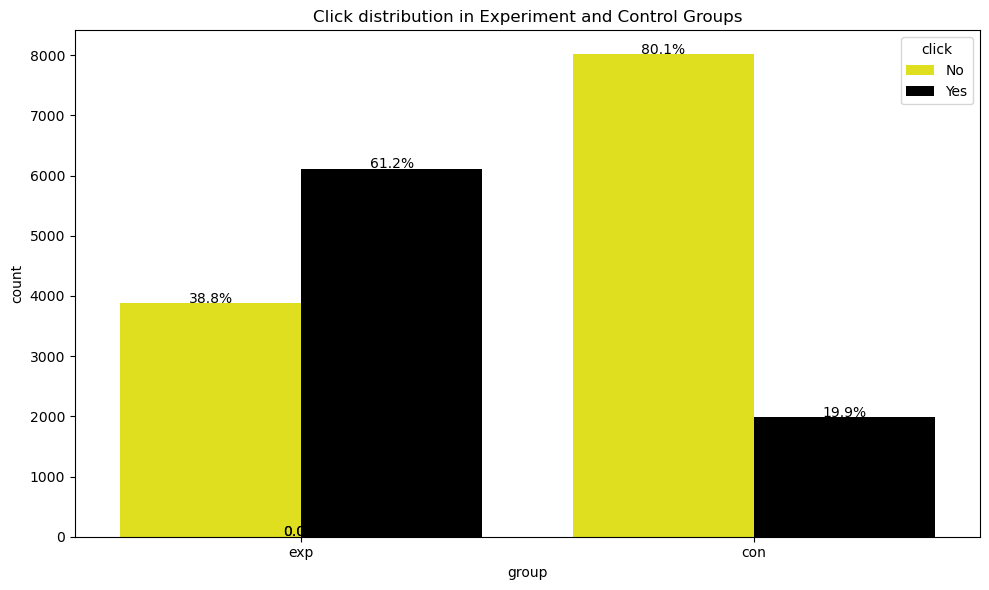

In [6]:
# custom pallete
palette={0:'yellow',1:'black'}  # assuming 0 is for no-click and 1 for click

# plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10,6))
ax=sns.countplot(x='group',hue='click',data=df_ab_test,palette=palette)
plt.title('Click distribution in Experiment and Control Groups')
plt.legend(title='click',labels=['No','Yes'])

# calculate the percentage and annot the bar
group_counts=df_ab_test.groupby(['group']).size()
group_click_counts=df_ab_test.groupby(['group','click']).size().reset_index(name='count')

for p in ax.patches:
    height=p.get_height()
    # find the group and the click type for the current bar
    group ='exp' if p.get_x()<0.5 else 'con'
    click=1 if p.get_x()%1 >0.5 else 0
    total=group_counts.loc[group]
    percentage=100*(height/total)
    ax.text(p.get_x()+ p.get_width()/2.,height+5,f'{percentage:.1f}%',ha='center',color='black',fontsize=10)
plt.tight_layout()
plt.show()

## Parameter of Model from power analysis

![](Param_model.png)

In [8]:
alpha=0.05  # 5%
print('Alpha: significance level is', alpha)

delta=0.1   # 10%
print('Delta: minimum detectable effect is:',delta)

Alpha: significance level is 0.05
Delta: minimum detectable effect is: 0.1


## calculating total number of clicks per group by summing clicks

In [9]:
N_con=df_ab_test[df_ab_test['group']=='con'].count().iloc[0]
N_exp=df_ab_test[df_ab_test['group']=='exp'].count().iloc[0]

# calculating the total number of clicks per group by summing 1's
X_con=df_ab_test.groupby('group')['click'].sum().loc['con']
X_exp=df_ab_test.groupby('group')['click'].sum().loc['exp']

#printing this for visibility
print(df_ab_test.groupby('group')['click'].sum())
print('Number of user in Control:',N_con)
print('Number of user in Experiment:',N_exp)
print('Number of clicks in control:',X_con)
print('Number of clicks in Experiment:',X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of user in Control: 10000
Number of user in Experiment: 10000
Number of clicks in control: 1989
Number of clicks in Experiment: 6116


## Calculating Pooled Estimates for Clicks per Group

In [10]:
# computing the estimate of click probability per group
p_con_hat=X_con/N_con
p_exp_hat=X_exp/N_exp
print('Click Probability in Control Group:',p_con_hat)
print('Click Probability in Experiment Group:',p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat=(X_con+X_exp)/(N_con+N_exp)
print(' Pooled Click Probability:', p_pooled_hat)

Click Probability in Control Group: 0.1989
Click Probability in Experiment Group: 0.6116
 Pooled Click Probability: 0.40525


## Calculting Pooled Variance

In [11]:
pooled_variance=p_pooled_hat*(1-p_pooled_hat)*(1/N_con+1/N_exp)
print('p^_pooled is:',p_pooled_hat)
print('pooled_variance is:',pooled_variance)

p^_pooled is: 0.40525
pooled_variance is: 4.82044875e-05


## Calculating Standard Error and Test Statistics

In [12]:
# comparing the standard error of the tst
SE= np.sqrt(pooled_variance)
print('Standard Error is:',SE)

# computing the test statistics of the Z-test
Test_stat=(p_con_hat-p_exp_hat)/SE
print('Test Statistics for 2-sample Z-test is:',Test_stat)

# critical value of Z-test
Z_crit=norm.ppf(1-alpha/2)   # percent point function
print('Z-critical value from Standard Normal distribution:',Z_crit)

Standard Error is: 0.006942945160376826
Test Statistics for 2-sample Z-test is: -59.44163326469381
Z-critical value from Standard Normal distribution: 1.959963984540054


## Calculating p_value of the Z_value

In [13]:
# calculate p value
p_value=2*norm.sf(abs(Test_stat))
print(p_value)
#function checking the statistical significance
def is_statistical_significance(p_value,alpha):
    '''
    we assess whether there is statistical significance based on the p_value and alpha.
    argument:
    - p value(float): the p-value resulting from a statistical test.
    - alpha (float,optional): the significance level threshold used to determine statistical significance. defaults to 0.05.

    return:
    - prints the assessment of the statistical significance.
    '''
    # print the rounded p-value to 3 decimal places
    print(f'p-value of the 2-sample Z-test: {p_value}')

    # determine statistical significance
    if p_value<=alpha:
        print(' There is statistical significance, indicating that the observed differences between the groups are unlikely to have occured by any chance alone.This suggests that the changes in the experimental group have a real effect compared to the control group.')
    else:
        print('There is no statistical significance, suggesting that the observed differences between the groups could have occured by any chance alone.This implies that the changes in the experimental group do not have a substantial effect compared to the control group.')

0.0


In [14]:
is_statistical_significance(p_value,alpha)

p-value of the 2-sample Z-test: 0.0
 There is statistical significance, indicating that the observed differences between the groups are unlikely to have occured by any chance alone.This suggests that the changes in the experimental group have a real effect compared to the control group.


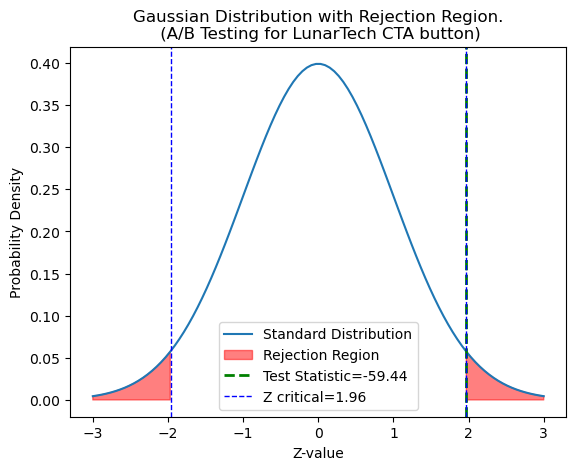

In [21]:
# Parameter for the standard normal distribution
mu=0   #mean
sigma=1   # standard deviation
x=np.linspace(mu-3*sigma,mu+3*sigma,100)
y=norm.pdf(x,mu,sigma)

# Plotting the standard normal distribution
plt.plot(x,y,label='Standard Distribution')

#shade the rejection region
plt.fill_between(x,y, where=(x>Z_crit) | (x<-Z_crit), color='red', alpha=0.5, label='Rejection Region')

# Adding Test statistic 
plt.axvline(Z_crit,color='green',linestyle='dashed',linewidth=2,label=f'Test Statistic={Test_stat:.2f}')

# Adding Z critical value
plt.axvline(Z_crit,color='blue',linestyle='dashed',linewidth=1,label=f'Z critical={Z_crit:.2f}')
plt.axvline(-Z_crit,color='blue',linestyle='dashed',linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region.\n (A/B Testing for LunarTech CTA button)')
plt.legend()

# show plot
plt.show()

# Calculating Confidence Interval of the test

In [16]:
# calculate the confidence interval (CI) for a 2 sample Z-test.
# calculate the lower and upper bounds of the confidence interval
CI=[
    round((p_exp_hat-p_con_hat)-SE*Z_crit,3), #lower bound of the CI, rounded to 3 decimal places
    round((p_exp_hat-p_con_hat)+SE*Z_crit,3)  #upper bound of hte CI, rounded to 3 decimal places
]

#print the calculated confidence interval
print('Confidence Interval of the 2 sample Z-test is:',CI)

# here, the confidence interval provides a range of values within which the true difference between the experimental and control group proportion is likely to lie with certain level of confidence (e.g. 95%)

Confidence Interval of the 2 sample Z-test is: [0.399, 0.426]


# Testing for Practical Significance in A/B Testing

In [19]:
def is_Practically_significant(delta,CI_95):
    '''
     We assess here if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE) parameter from the Power Analysis.

    Arguments:
    - delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.

    Returns:
    - Prints whether the experiment has practical significance based on the MDE and CI.
    '''
    # Extract lower bound of 95% confidence interval
    lower_bound_CI=CI_95[0]
    if lower_bound_CI>=delta:
        print(f"We have practical significance! \nWith MDE of {delta}, The difference between Control and Experimental group is practically significant.")
        return True
    else:
        print("We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant.")
        return False


# Call the function
significance = is_Practically_significant(delta, CI)
print("Lower bound of 95% confidence interval is: ", CI[0])

We have practical significance! 
With MDE of 0.1, The difference between Control and Experimental group is practically significant.
Lower bound of 95% confidence interval is:  0.399
